# Cardiovascular Deaths Regression Models and Analysis

---

**Importing Model Dependencies**

In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve


# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import validation_curve
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# For QQ plot
from statsmodels.graphics.gofplots import qqplot


# To surpress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data

df = pd.read_csv(r"C:\Users\rave_consolidate\Desktop\cadiovascular_death\dataset\trainset.csv")
df_test = pd.read_csv(r"C:\Users\rave_consolidate\Desktop\cadiovascular_death\dataset\testset.csv")

In [3]:
df.head()

,year,code,temp_change,CO2,cardio_deaths
0,1991,AFG,0.000891,14436271.0,266.298725
1,1992,AFG,0.000891,13517736.0,224.447196
2,1993,AFG,0.000890,12913293.0,278.393699
3,1996,AFG,0.000888,16127630.0,315.446081
4,2004,AFG,0.000936,20214652.0,332.240918


In [4]:
df_test.head()

,year,code,temp_change,CO2
0,2022,ESP,4.248217e-06,306905.00
1,2022,ESP,5.498951e-07,55276.00
2,2022,ESP,5.412198e-05,4333367.00
3,2022,ESP,1.100690e-06,51516.69
4,2022,ESP,2.369140e-07,13152.00


In [5]:
df.columns

Index(['year', 'code', 'temp_change', 'CO2', 'cardio_deaths'], dtype='object')

In [6]:
# preprosses code as category

df.code = df.code.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   year           3431 non-null   int64   
 1   code           3431 non-null   category
 2   temp_change    3431 non-null   float64 
 3   CO2            3431 non-null   float64 
 4   cardio_deaths  3431 non-null   float64 
dtypes: category(1), float64(3), int64(1)
memory usage: 119.3 KB


In [7]:
# Function to calculate RMSE

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [8]:
# Function to plot predicted vs Actual

def plot_predicted_vs_actual(y_test, y_pred):
    """
    Plot Predicted vs Actual values.
    
    Parameters:
    y_test (array-like): True values
    y_pred (array-like): Predicted values
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()


In [9]:
def plot_qq(y_test, y_pred):
    """
    Create a QQ plot of residuals for model evaluation.
    
    Parameters:
    y_test (array-like): True values
    y_pred (array-like): Predicted values
    """
    residuals = y_test - y_pred
    sm.qqplot(residuals, line='45')
    plt.title('QQ Plot of Residuals')
    plt.show()

In [28]:
# Define features and target

X = df.drop(columns=['cardio_deaths'])
y = df['cardio_deaths']

In [29]:
# Column selectors

numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

In [30]:
X.head()

,year,code,temp_change,CO2
0,1991,AFG,0.000891,14436271.0
1,1992,AFG,0.000891,13517736.0
2,1993,AFG,0.000890,12913293.0
3,1996,AFG,0.000888,16127630.0
4,2004,AFG,0.000936,20214652.0


In [31]:
y[:5]

0    266.298725
1    224.447196
2    278.393699
3    315.446081
4    332.240918
Name: cardio_deaths, dtype: float64

In [13]:
# spilt the data set using the train-test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### XGBOOST Regressor Base Model

---

In [38]:
# Target Transformation

target_transformer = PowerTransformer(method='yeo-johnson')
y_train_transformed = target_transformer.fit_transform(y_train)
y_test_transformed = target_transformer.transform(y_test)

In [65]:
# Column transformer for preprocessing
preprocessor = ColumnTransformer(
        transformers=[
            ('num', PowerTransformer(method='yeo-johnson'), numerical_features),
            ('cat', CatBoostEncoder(), categorical_features)
        ])

In [66]:
# Full pipeline with preprocessor and model

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
])

In [67]:
# Model Training
pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  ['year', 'temp_change',
                                                   'CO2']),
                                                 ('cat', CatBoostEncoder(),
                                                  ['code'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eva...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

0.9885641876017153

In [18]:
# Model Evaluation

y_train_pred_transformed = pipeline.predict(X_train)
y_test_pred_transformed = pipeline.predict(X_test)

In [70]:
# Train Score

pipeline.score(X_train, y_train_pred_transformed)

0.9885641876017153

In [71]:
# Test score

pipeline.score(X_test, y_test_pred_transformed)

0.9898116814594369

In [72]:
# Inverse transform predictions
y_train_pred = target_transformer.inverse_transform(y_train_pred_transformed.reshape(-1, 1))
y_test_pred = target_transformer.inverse_transform(y_test_pred_transformed.reshape(-1, 1))

In [73]:
# RMSE evaluation

print(rmse(y_train, y_train_pred))
print(rmse(y_test, y_test_pred))

25.45636438940774
33.46749835832372


In [74]:
# r2_scored evaluation

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

0.9010222331188789
0.8386872578074117


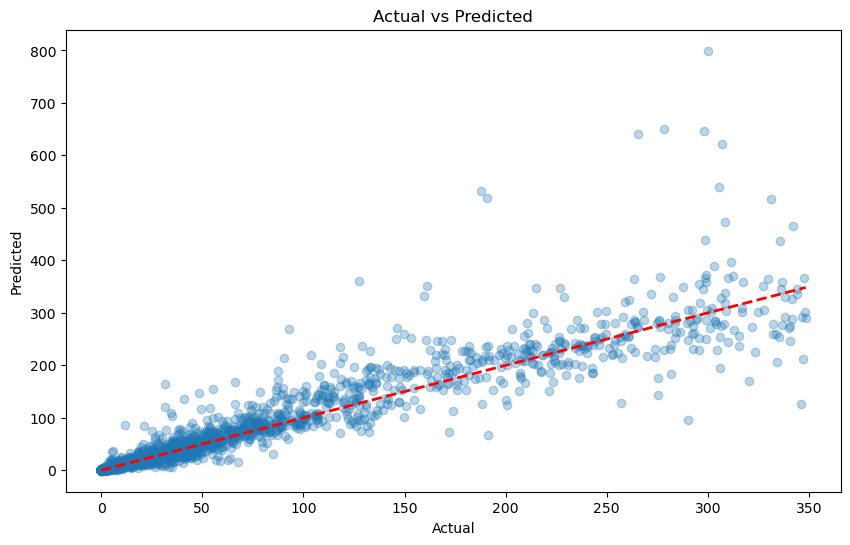

In [22]:
plot_predicted_vs_actual(y_train, y_train_pred)

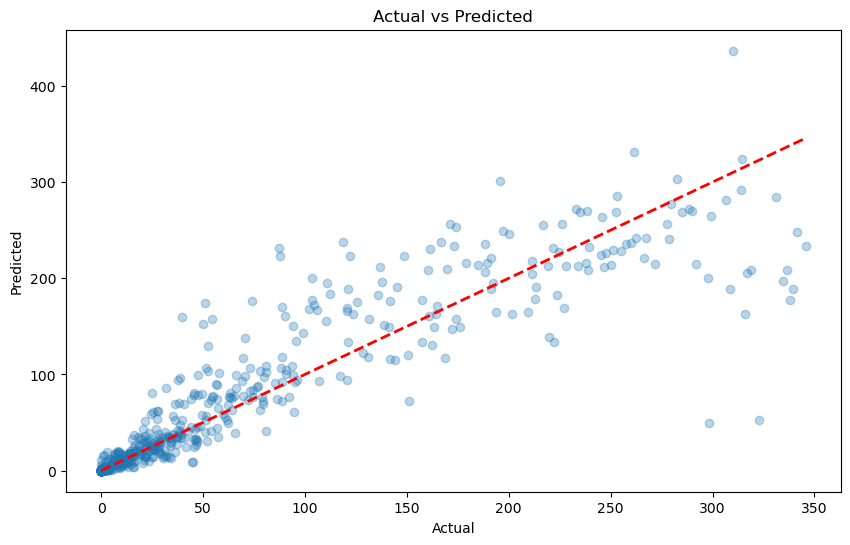

In [76]:
# plot predicted vs actuals

plot_predicted_vs_actual(y_test, y_test_pred)

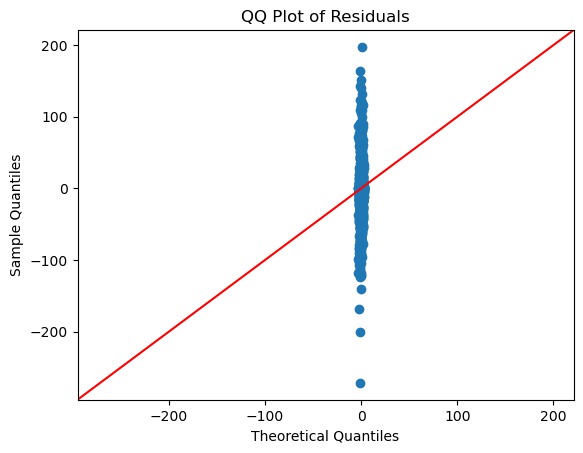

In [77]:
# plot the qqplot

plot_qq(y_train, y_train_pred)

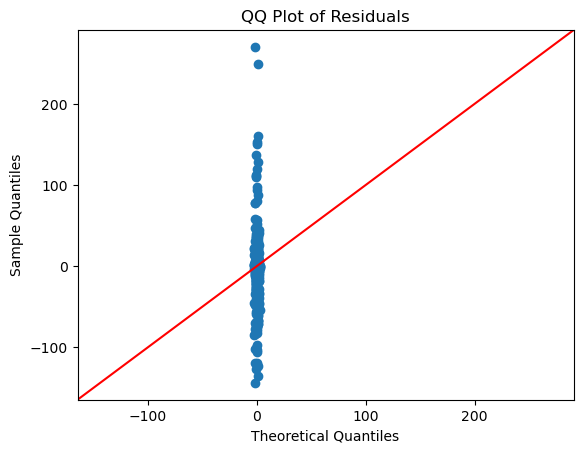

In [78]:
# plot qqplot for test data

plot_qq(y_test, y_test_pred)

### Catboost Regressor Base Model

---

In [42]:
# Define the target transformer
pt_target = PowerTransformer(method='yeo-johnson')

# Transform the target variable
y_train_transformed = pt_target.fit_transform(y_train.reshape(-1, 1))
y_test_transformed = pt_target.transform(y_test.reshape(-1, 1))


In [43]:
# Define the preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(method='yeo-johnson'), numerical_features),
        ('cat', CatBoostEncoder(cols=categorical_features), categorical_features)
    ],
    remainder='passthrough'
)


In [46]:
# Define the pipeline

cat_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(verbose=0))
])

In [50]:
# Fit the pipeline to the training data

cat_pipeline.fit(X_train, y_train_transformed.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', PowerTransformer(),
                                                  ['year', 'temp_change',
                                                   'CO2']),
                                                 ('cat',
                                                  CatBoostEncoder(cols=['code']),
                                                  ['code'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x00000245B340ED90>)])

In [51]:
# Model Evaluation

y_cat_train_pred_transformed = cat_pipeline.predict(X_train)
y_cat_test_pred_transformed = cat_pipeline.predict(X_test)

In [56]:
# inverse transform the predictions

y_train_cat_pred = pt_target.inverse_transform(y_cat_train_pred_transformed.reshape(-1, 1))
y_test_cat_pred = pt_target.inverse_transform(y_cat_test_pred_transformed.reshape(-1, 1))

In [57]:
# RMSE evaluation

print(rmse(y_train, y_train_cat_pred))
print(rmse(y_test, y_test_cat_pred))

25.45636438940774
33.46749835832372


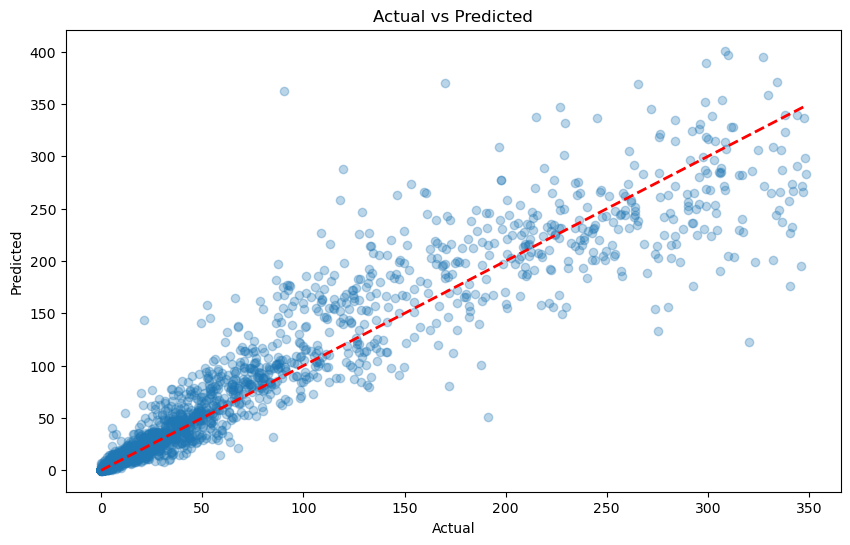

In [58]:
# plot predicted vs actual for train set

plot_predicted_vs_actual(y_train, y_train_cat_pred)

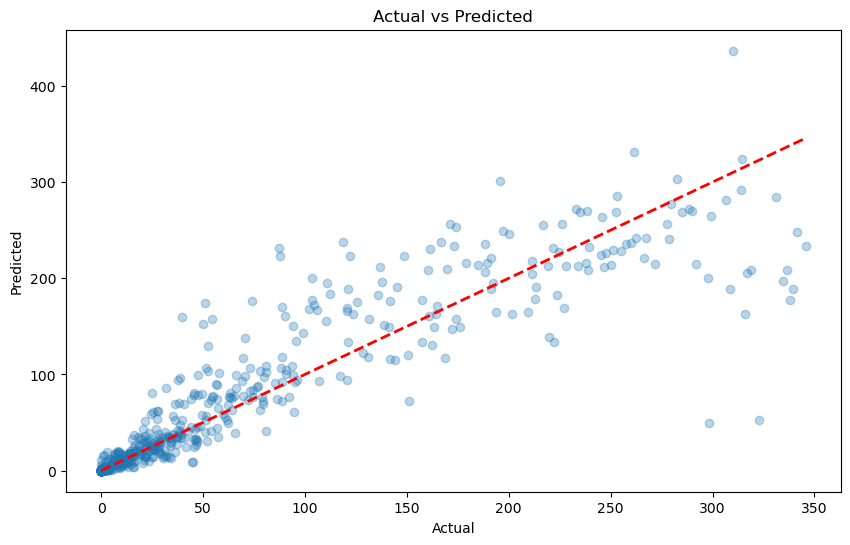

In [59]:
# plot predicted vs actual for test set

plot_predicted_vs_actual(y_test, y_test_cat_pred)

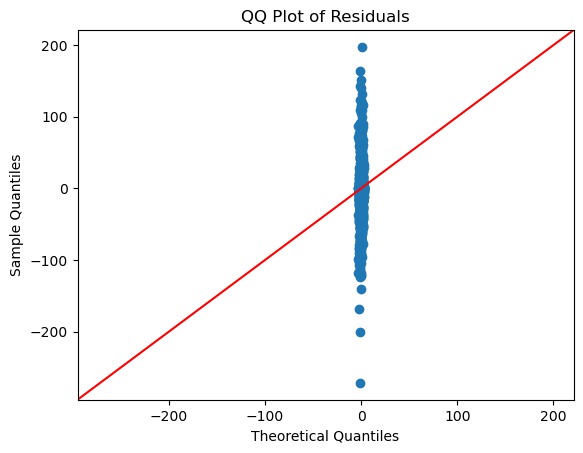

In [60]:
# qq plot for train set

plot_qq(y_train, y_train_cat_pred)

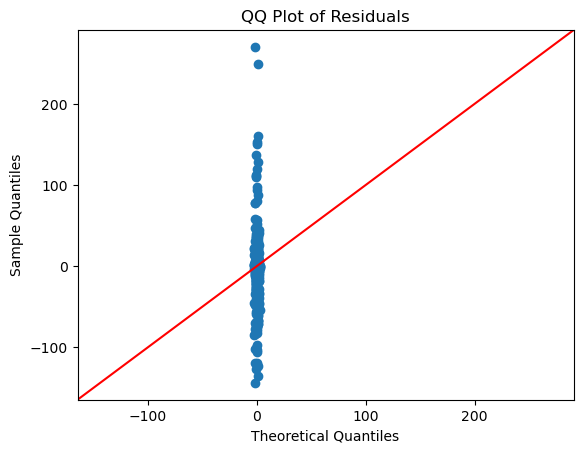

In [61]:
# qq plot for test set

plot_qq(y_test, y_test_cat_pred)

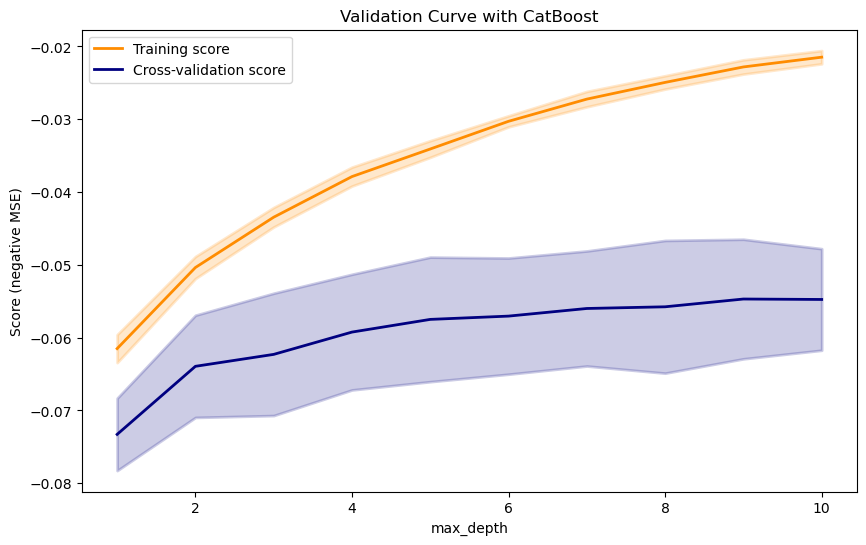

In [81]:
# Define the parameter range for max_depth
param_range = np.arange(1, 11, 1)

# Compute the training and test scores
train_scores, test_scores = validation_curve(
    cat_pipeline,
    X_train,
    y_train_transformed,
    param_name='regressor__max_depth',  # parameter name for the CatBoostRegressor
    param_range=param_range,
    cv=5,
    scoring='neg_mean_squared_error'
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with CatBoost")
plt.xlabel("max_depth")
plt.ylabel("Score (negative MSE)")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,   
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


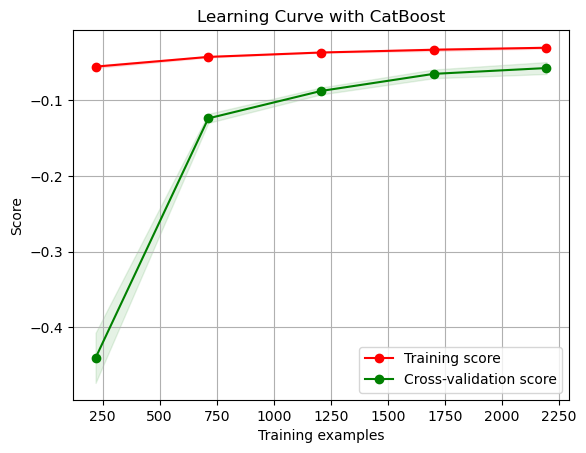

In [82]:
from sklearn.model_selection import learning_curve

# Set the range for the number of training samples
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    cat_pipeline, X_train, y_train_transformed, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve with CatBoost")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot training score
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

# Plot cross-validation score
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

 ### The learning curve provides several insights into the performance and behavior of your CatBoost model:

1. **Training Score (Red Curve)**: The training score is relatively high, indicating that the model is fitting the training data well. There is a slight increase in training score as the number of training examples increases, which is typical as the model learns from more data.

2. **Cross-Validation Score (Green Curve)**: The cross-validation score shows a significant improvement as the number of training examples increases. Initially, the cross-validation score is much lower, but it improves and stabilizes as more training data is used.

3. **Gap Between Training and Cross-Validation Scores**: The gap between the training and cross-validation scores decreases as the number of training examples increases. This suggests that the model is benefiting from more data and is likely to generalize better with more training data.

4. **Stabilization**: Both the training and cross-validation scores stabilize towards the end, indicating that the model's performance is converging and additional data may not significantly improve the model.

### Interpretation:
- The initial large gap between the training and cross-validation scores suggests that the model might have been overfitting with smaller training sets.
- As the number of training examples increases, the gap narrows, and the cross-validation score improves, indicating better generalization.

### Next Steps:
- **Additional Data**: If possible, adding more training data might help improve the model's performance further, though the current curve suggests it is already quite stable.
- **Hyperparameter Tuning**: Fine-tuning hyperparameters could help in closing any remaining gap between training and validation scores and potentially improve the model's performance.
- **Feature Engineering**: Consider adding or transforming features to provide more information to the model.

This learning curve indicates that your model is performing reasonably well and additional data or fine-tuning could further enhance its performance. Overall the catboost model performed better than the XGBoost

### LightGBM Regressor

---

In [83]:
# Define the preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(method='yeo-johnson'), numerical_features),
        ('cat', CatBoostEncoder(cols=categorical_features), categorical_features)
    ],
    remainder='passthrough'
)

In [84]:
# Define the pipeline with LightGBM model
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor())
])

In [85]:
# Train the pipeline
lgb_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', PowerTransformer(),
                                                  ['year', 'temp_change',
                                                   'CO2']),
                                                 ('cat',
                                                  CatBoostEncoder(cols=['code']),
                                                  ['code'])])),
                ('regressor', LGBMRegressor())])

In [86]:
# Model Evaluation

y_lgb_train_pred_transformed = lgb_pipeline.predict(X_train)
y_lgb_test_pred_transformed = lgb_pipeline.predict(X_test)

In [87]:
# inverse transform the predictions

y_train_lgb_pred = pt_target.inverse_transform(y_lgb_train_pred_transformed.reshape(-1, 1))
y_test_lgb_pred = pt_target.inverse_transform(y_lgb_test_pred_transformed.reshape(-1, 1))

In [163]:
# RMSE evaluation
print(f"Train rmse for first lgbm model: {rmse(y_train, y_train_lgb_pred)}")
print(f"Test rmse for the first lgbm model: {rmse(y_test, y_test_lgb_pred)}")

# r2 scored evaluation
print(f"r2 score for 1st train lgbm model: {r2_score(y_train, y_train_lgb_pred)}")
print(f"r2 sscore for the 1st test lgbm model: {r2_score(y_test, y_test_lgb_pred)}")

Train rmse for first lgbm model: 24.979547024372444
Test rmse for the first lgbm model: 32.9593619116976
r2 score for 1st train lgbm model: 0.9046953676068934
r2 sscore for the 1st test lgbm model: 0.8435484886453902


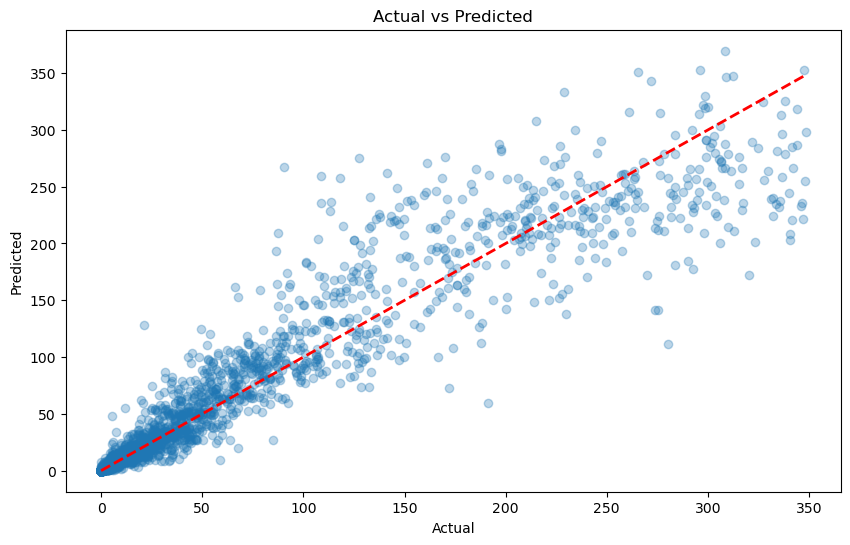

In [89]:
# plot predicted vs actual for train set

plot_predicted_vs_actual(y_train, y_train_lgb_pred)

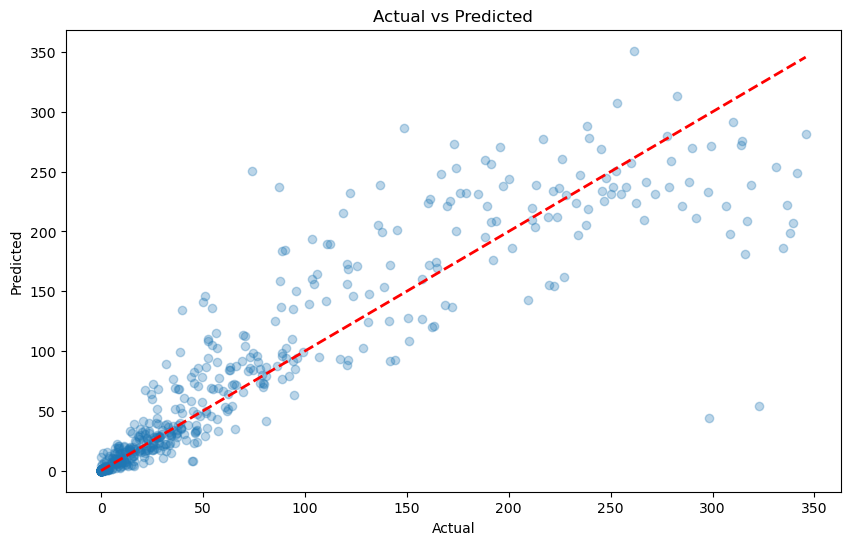

In [90]:
# plot predicted vs actual for test set

plot_predicted_vs_actual(y_test, y_test_lgb_pred)

In [92]:
# Check the score for the train data

lgb_pipeline.score(X_train, y_lgb_train_pred_transformed)

1.0

In [93]:
# Check the score for the test set

lgb_pipeline.score(X_test, y_lgb_test_pred_transformed)

1.0

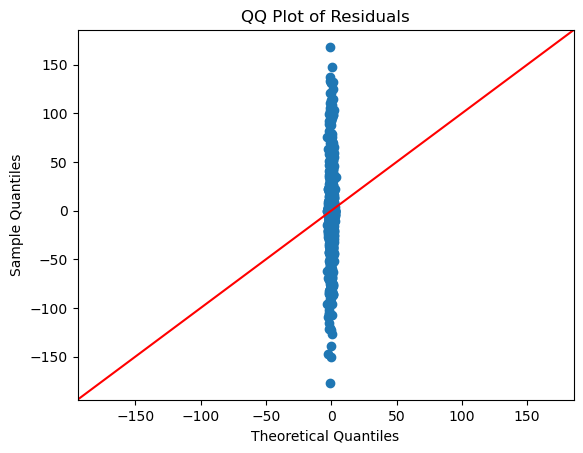

In [95]:
# qq plot for train set

plot_qq(y_train, y_train_lgb_pred)

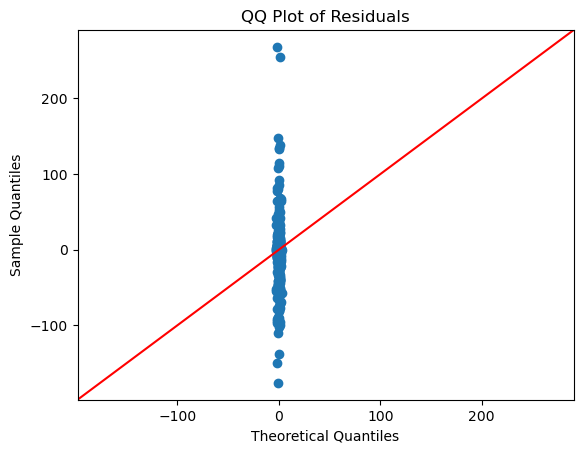

In [96]:
# qq plot for train set

plot_qq(y_test, y_test_lgb_pred)

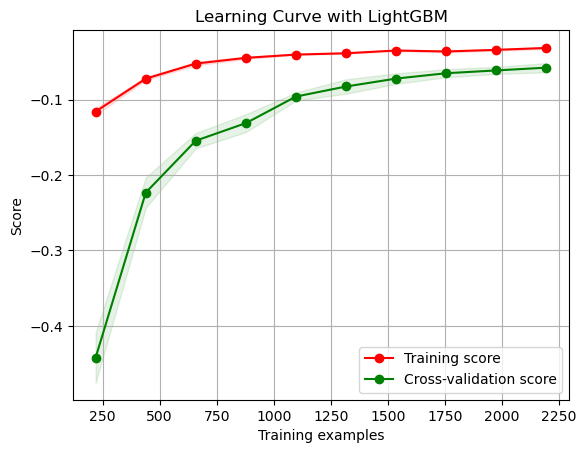

In [102]:
# Generate the learning curve

train_sizes, train_scores, test_scores = learning_curve(
    lgb_pipeline,
    X_train,
    y_train_transformed,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve with LightGBM")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

# Plot the cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

The learning curves suggest that the LightGBM model generalizes slightly better than the CatBoost model on the given dataset. Here's a detailed comparison based on the learning curves:

#### CatBoost
- **Training Score**: Starts high and increases with more training examples, indicating that the model fits the training data well.
- **Cross-Validation Score**: Starts lower but improves significantly as the training set size increases. However, there is a notable gap between the training and cross-validation scores, suggesting some overfitting.

#### LightGBM
- **Training Score**: Also starts high and shows a slight increase with more training examples, indicating good fit on the training data.
- **Cross-Validation Score**: Starts lower but steadily improves as the training set size increases. The gap between the training and cross-validation scores is smaller compared to CatBoost, indicating better generalization and less overfitting.

#### Interpretation
- **Generalization**: LightGBM has a smaller gap between the training and cross-validation scores, suggesting it generalizes better to unseen data compared to CatBoost.
- **Overfitting**: CatBoost shows a larger gap between training and cross-validation scores, indicating it may be overfitting more than LightGBM.

#### Conclusion
Based on the learning curves, **LightGBM appears to perform better than CatBoost** for this specific dataset and current settings. This conclusion is primarily due to LightGBM's better generalization and smaller overfitting gap.

#### Next Steps for Validation
To confirm this preliminary conclusion, it is important to:
1. **Hyperparameter Tuning**: Perform thorough hyperparameter tuning for both models to ensure they are optimally configured.
2. **Cross-Validation**: Conduct cross-validation with more folds to ensure robustness of the results.

**We'll be proceeding with the lightGBMregressor since it generalizes well with the data and no over fitting**


### Final Model

---

In [106]:
# we'll be using the hyperopt for further hyper parameter tunning

# pip install hyperopt

In [109]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [110]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(method='yeo-johnson'), numerical_features),
        ('cat', CatBoostEncoder(cols=categorical_features), categorical_features)
    ],
    remainder='passthrough'
)

In [111]:
# Create a function for the pipeline

def create_pipeline(params):
    model = lgb.LGBMRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        num_leaves=int(params['num_leaves']),
        min_child_samples=int(params['min_child_samples']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

In [125]:
def objective(params):
    # create the pipeline
    pipeline = create_pipeline(params)
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict using the trained model
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Return the metrics as a dictionary
    return {'loss': rmse, 'status': STATUS_OK, 'r2': r2}

In [113]:
# Create the search space for the hyperopt tunning

search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 50)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 5)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 50, 5)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}


In [126]:
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

print("Best hyperparameters:", best_params)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:04<00:00,  1.30s/trial, best loss: 28.767926376031816]
Best hyperparameters: {'colsample_bytree': 0.7376115077576679, 'learning_rate': 0.030084824004602675, 'min_child_samples': 30.0, 'n_estimators': 150.0, 'num_leaves': 80.0, 'reg_alpha': 0.8139476256903809, 'reg_lambda': 0.22916281859391535, 'subsample': 0.6609752806165173}


In [127]:
# Best parameters for training the model

best_params

{'colsample_bytree': 0.7376115077576679,
 'learning_rate': 0.030084824004602675,
 'min_child_samples': 30.0,
 'n_estimators': 150.0,
 'num_leaves': 80.0,
 'reg_alpha': 0.8139476256903809,
 'reg_lambda': 0.22916281859391535,
 'subsample': 0.6609752806165173}

In [128]:
# create a pipeline with the best parameters

model_pipeline = create_pipeline(best_params)

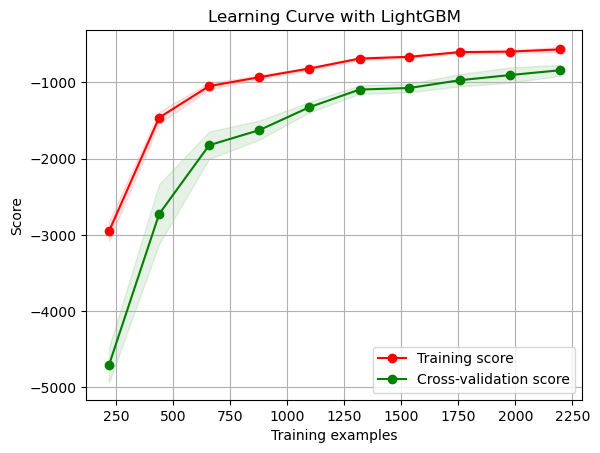

In [130]:
# Generate the learning curve

train_sizes, train_scores, test_scores = learning_curve(
    model_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve with LightGBM")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

# Plot the cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

**Train for Production**

In [131]:
# Create a function to plot the learning and evaluaiton curve

def plot_learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        train_sizes=train_sizes
    )

    # Calculate the mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    # Plot the training scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

    # Plot the cross-validation scores
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [159]:
# Evaluation

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict using the trained model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"RMSE for training: {rmse_train:.4f}")
    print(f"R² for training: {r2_train:.4f}")
    print(f"RMSE for validation: {rmse_test:.4f}")
    print(f"R² for validation: {r2_test:.4f}")

In [161]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, plot_learning=True):
    # Train the model
    model.fit(X_train, y_train)
    
    # Optionally plot the learning curve
    if plot_learning:
        plot_learning_curve(model, X_train, y_train)
    
    # Evaluate the model
    evaluate_model(model, X_train, y_train, X_test, y_test)

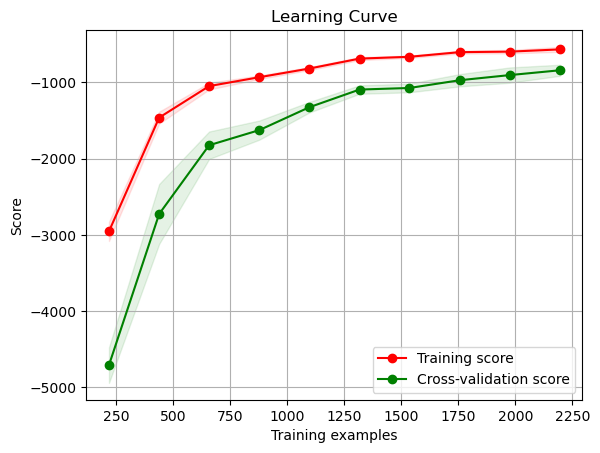

RMSE for training: 22.7707
R² for training: 0.9208
RMSE for validation: 28.7679
R² for validation: 0.8808


In [162]:
# Train and evaluate the model
train_and_evaluate(model_pipeline, X_train, y_train, X_test, y_test)

#### Based on the comparison of the metrics:

1. **The newer model** shows better performance with lower RMSE and higher R² values for both training and validation datasets.

2. **Recommendation**:
   - Use the newer model for production as it demonstrates superior predictive performance and better generalization to unseen data.
   - Ensure to retrain the model on the entire dataset using the best hyperparameters obtained from hyperparameter tuning.
   - Save the trained model to use it for future predictions and ensure consistency in your deployment environment.
   - Continuous monitoring of the model's performance over time and periodically retraining it with new data will maintain its accuracy and relevance.

#### Saving the models for prediction

In [135]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', PowerTransformer(),
                                                  ['year', 'temp_change',
                                                   'CO2']),
                                                 ('cat',
                                                  CatBoostEncoder(cols=['code']),
                                                  ['code'])])),
                ('model',
                 LGBMRegressor(colsample_bytree=0.7376115077576679,
                               learning_rate=0.030084824004602675,
                               min_child_samples=30, n_estimators=150,
                               num_leaves=80, reg_alpha=0.8139476256903809,
                               reg_lambda=0.22916281859391535,
                               subsample=0.6609752806165173))])

In [137]:
# Function to save the model

import joblib

def save_model(model, filename):
    try:
        joblib.dump(model, filename)
        print(f"Model saved as {filename}")
    except Exception as e:
        print(f"Error saving model: {e}")

In [138]:
# save the trained model

save_model(model_pipeline, 'model.pkl')

Model saved as model.pkl


In [140]:
# Function to load the saved model

def load_model(filename):
    try:
        model = joblib.load(filename)
        print(f"Model loaded from {filename}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

In [146]:
df_test.head()

,year,code,temp_change,CO2
0,2022,ESP,4.248217e-06,306905.00
1,2022,ESP,5.498951e-07,55276.00
2,2022,ESP,5.412198e-05,4333367.00
3,2022,ESP,1.100690e-06,51516.69
4,2022,ESP,2.369140e-07,13152.00


In [143]:
# make prediction for the df_test data
# load the saved model
saved_model = load_model('model.pkl')

# Make predictions using the loaded model
if saved_model:
    predictions = saved_model.predict(df_test)
    print(predictions[:])

Model loaded from model.pkl
[16.12775808 16.20544213 29.37340189 16.20544213 16.20544213 95.59630485
 16.20544213 16.20544213 16.20544213 16.20544213 16.20544213 16.12775808
 16.12775808 78.52548275 16.12775808 16.20544213 16.12775808 78.64542304
 67.31988726 16.12775808 16.20544213 16.20544213 16.20544213 16.20544213
 16.27352394 16.20544213 90.29243541 17.83495961 78.54515399 16.20544213
 15.45500081 16.20544213 18.51554876 16.20544213 16.27352394]


In [165]:
# make custom predictions
# Prepare the input data as a DataFrame
input_data = pd.DataFrame({
    'year': [1980],
    'code': ['CHN'],
    'temp_change': [6.248217e+06],
    'CO2': [50000.00]
})


# Make predictions using the loaded model
predictions = saved_model.predict(input_data)

print(predictions)

[68.56895165]


### For Production, use the following dependables

In [166]:
# ## For Production, use the following dependables

# # Import basic libraries
# import numpy as np
# import pandas as pd

# # Import LightGBM
# import lightgbm as lgb
# from lightgbm import LGBMRegressor

# # Import Scikit-Learn utilities
# from sklearn.model_selection import train_test_split, learning_curve
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, PowerTransformer

# # Import CatBoostEncoder for categorical encoding
# from category_encoders import CatBoostEncoder

# # Import joblib for model serialization
# import joblib

# # Import matplotlib for plotting
# import matplotlib.pyplot as plt

# # Import seaborn for enhanced plotting (optional)
# import seaborn as sns
# sns.set(style="whitegrid")

# # Set random seed for reproducibility
# import os
# import random
# SEED = 42
# np.random.seed(SEED)
# random.seed(SEED)


**Note:**

- Remember to pass your inputs into a data frame to stage it for prediction with the model as I used a pandas dataframe object for the prediction directly